Prediction of hate speech and offensive tweets

In [1]:
#Importing all necessary libraries
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import make_pipeline
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import resample

In [2]:
#Loading the dataset
dataset = panda.read_csv("HateSpeechData.csv")
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [3]:
#Count of offensive, hate speech and neither lables in the dataset
Class_Count_0,Class_Count_1,Class_Count_2=dataset['class'].value_counts()
class_0 = dataset[dataset['class'] == 0]
class_1 = dataset[dataset['class'] == 1]
class_2 = dataset[dataset['class'] == 2]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print('class 2:', class_2.shape) 

class 0: (1430, 7)
class 1: (19190, 7)
class 2: (4163, 7)


In [4]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
print(dataset.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  text length  
0  !!! RT @mayasolovely: As a woman you shouldn't...          140  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137  


In [5]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

Preprocessing of tweets

In [6]:
###Performing the text pre-processing to achieve the cleaner dataset that can be used for the feature engineering. 
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming
## 5. Removal of extra spaces,name, links etc....

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|' '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
print(dataset[["tweet","processed_tweets"]].head(10))

                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
6  !!!!!!"@__BrighterDays: I can not just sit up ...   
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
8  " &amp; you might not get ya bitch back &amp; ...   
9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                    processed_tweets  
0  woman complain clean hous amp man alway take t...  
1  boy dat cold tyga dwn bad cuffin dat hoe st place  
2         dawg ever fuck bitch start cri confus shit  
3                                   look like tranni  
4     shit hear might true might faker bitch told ya  
5      shit blow claim faith somebodi still fuck hoe 

Feature Engineering

In [7]:
#TF-IDF Features-F1
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189618 stored elements in Compressed Sparse Row format>

Running Various models using TFIDF without adding additional featires.

              precision    recall  f1-score   support

           0       0.56      0.18      0.27       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.84      0.85       835

    accuracy                           0.90      4957
   macro avg       0.77      0.66      0.68      4957
weighted avg       0.88      0.90      0.88      4957

Logistic Regression, Accuracy Score: 0.8975186604801291
[[  51  212   27]
 [  38 3693  101]
 [   2  128  705]]


/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


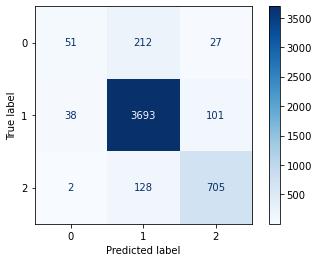

In [8]:
#Logistic Regression Model
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
classNames = np.unique(y_test)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)
## plotting confusion matrix for better visualization
print(confusion_matrix( y_test, y_preds))
plottedCM_Level_A = plot_confusion_matrix(model,  X_test_tfidf , y_test ,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()


<AxesSubplot:>

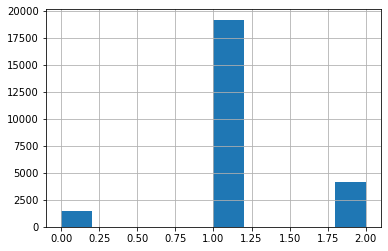

In [9]:
#The above histogram shows that most of the tweets are considered to be offensive words by the CF coders.
dataset['class'].hist()

              precision    recall  f1-score   support

           0       0.49      0.16      0.24       290
           1       0.93      0.96      0.94      3832
           2       0.83      0.92      0.87       835

    accuracy                           0.90      4957
   macro avg       0.75      0.68      0.69      4957
weighted avg       0.89      0.90      0.89      4957

Random Forest, Accuracy Score: 0.9031672382489409
[[  47  206   37]
 [  44 3663  125]
 [   5   63  767]]


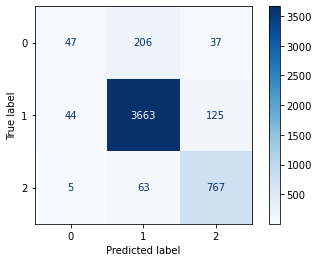

In [10]:
#Random Forest Model
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
classNames = np.unique(y_test)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)
## plotting confusion matrix for better visualization
print(confusion_matrix( y_test, y_preds))
plottedCM_Level_A = plot_confusion_matrix(rf,  X_test_tfidf , y_test ,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.58      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957

Naive Bayes, Accuracy Score: 0.6491829735727255
[[ 114  127   49]
 [ 851 2617  364]
 [ 153  195  487]]


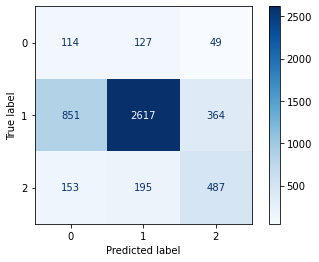

In [11]:
#GaussianNB classifier
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
classNames = np.unique(y_test)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)
## plotting confusion matrix for better visualization
print(confusion_matrix( y_test, y_preds))
plottedCM_Level_A = plot_confusion_matrix(nb,  X_test_tfidf , y_test ,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()

[[  76  186   28]
 [  74 3641  117]
 [  14  110  711]]
              precision    recall  f1-score   support

           0       0.46      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.70      4957
weighted avg       0.88      0.89      0.89      4957

SVM, Accuracy Score: 0.8932822271535202
[[  76  186   28]
 [  74 3641  117]
 [  14  110  711]]


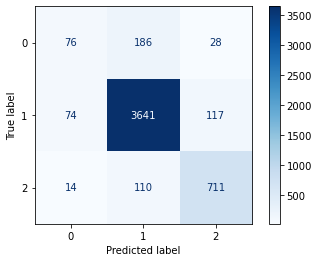

In [12]:
#SVM classifier
classNames = np.unique(y_test)
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(confusion_matrix( y_test, y_preds))
print(report)
print("SVM, Accuracy Score:" , acc3)
## plotting confusion matrix for better visualization
print(confusion_matrix( y_test, y_preds))
plottedCM_Level_A = plot_confusion_matrix(support,  X_test_tfidf , y_test ,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()

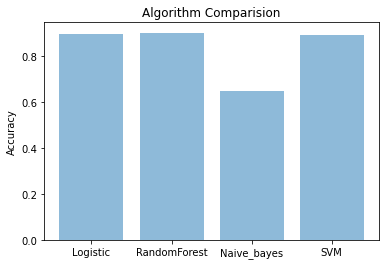

In [13]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

In [14]:
##a lexicon and rule-based sentiment analysis tool that is specifically attuned to 
##sentiments expressed in social media, and works well on texts from other domains.
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mc6362/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
#Sentiment Analysis, using polarity scores as features
sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24780,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [16]:
# sentiment scores
#tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([final_features],axis=1)
modelling_features.shape

(24783, 7)

In [17]:
##Extraction of some unique and important features and combining them in different sets for the purpose of 
#comparision and analysis.

# Running the model Using some features from sentiment analysis

X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression,Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       290
           1       0.79      0.98      0.87      3832
           2       0.57      0.15      0.23       835

    accuracy                           0.78      4957
   macro avg       0.45      0.37      0.37      4957
weighted avg       0.71      0.78      0.71      4957

Logistic Regression,Accuracy Score: 0.7799072019366552


/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.autofs/tools/spack/var/spack/environments/reu

In [18]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.19      0.04      0.07       290
           1       0.80      0.94      0.86      3832
           2       0.46      0.21      0.29       835

    accuracy                           0.76      4957
   macro avg       0.48      0.40      0.41      4957
weighted avg       0.70      0.76      0.72      4957

Random Forest, Accuracy Score: 0.7629614686302199


In [19]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_bow,y_train)
y_preds = nb.predict(X_test_bow)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.19      0.02      0.03       290
           1       0.87      0.74      0.80      3832
           2       0.37      0.74      0.49       835

    accuracy                           0.70      4957
   macro avg       0.48      0.50      0.44      4957
weighted avg       0.75      0.70      0.70      4957

Naive Bayes, Accuracy Score: 0.6994149687310873


In [20]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       290
           1       0.78      1.00      0.87      3832
           2       0.69      0.03      0.05       835

    accuracy                           0.78      4957
   macro avg       0.49      0.34      0.31      4957
weighted avg       0.72      0.78      0.68      4957

SVM, Accuracy Score: 0.7754690336897317


/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

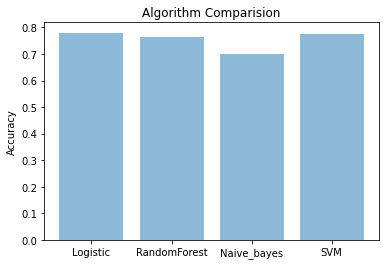

In [21]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F1')
plt.show()

In [22]:
# conctaenation of tf-idf scores, sentiment scores 
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 6448)

Running the models Using TFIDF with additional features from sentiment analysis



/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.60      0.18      0.28       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.85      0.85       835

    accuracy                           0.90      4957
   macro avg       0.79      0.67      0.69      4957
weighted avg       0.89      0.90      0.89      4957

Logistic Regression, Accuracy Score: 0.8999394795239056
[[  53  207   30]
 [  35 3697  100]
 [   1  123  711]]


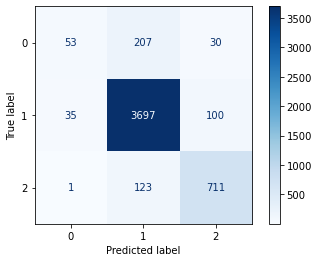

In [33]:
#Running the models Using TFIDF with additional features from sentiment analysis
#Logistic regression consistently performed well with all features.
X = panda.DataFrame(modelling_features)
classNames = np.unique(y_test)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)
## plotting confusion matrix for better visualization
print(confusion_matrix( y_test, y_preds))
plottedCM_Level_A = plot_confusion_matrix(model,  X_test_bow , y_test ,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()


              precision    recall  f1-score   support

           0       0.51      0.13      0.21       290
           1       0.91      0.97      0.94      3832
           2       0.85      0.84      0.84       835

    accuracy                           0.90      4957
   macro avg       0.76      0.64      0.66      4957
weighted avg       0.88      0.90      0.88      4957

Random Forest, Accuracy Score: 0.8950978414363526
[[  38  227   25]
 [  33 3699  100]
 [   3  132  700]]


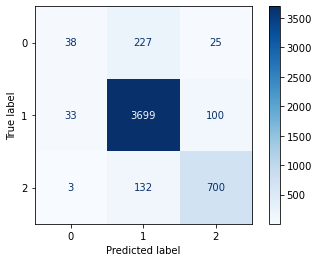

In [34]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
classNames = np.unique(y_test)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)
## plotting confusion matrix for better visualization
print(confusion_matrix( y_test, y_preds))
plottedCM_Level_A = plot_confusion_matrix(rf,  X_test_bow , y_test ,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.59      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957

Naive Bayes, Accuracy Score: 0.650191648174299
[[ 114  127   49]
 [ 851 2620  361]
 [ 151  195  489]]


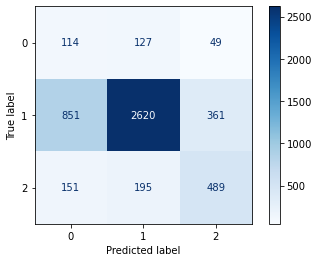

In [35]:
#Overall naive bayes results are fount to be less signifiacnt compared to other classifiers.
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
classNames = np.unique(y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)
## plotting confusion matrix for better visualization
print(confusion_matrix( y_test, y_preds))
plottedCM_Level_A = plot_confusion_matrix(nb,  X_test , y_test ,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()

/.autofs/tools/spack/var/spack/environments/reu-sep-21062801/.spack-env/view/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

           0       0.45      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.73      0.69      0.70      4957
weighted avg       0.88      0.89      0.88      4957

SVM, Accuracy Score: 0.8912648779503732
[[  75  188   27]
 [  76 3634  122]
 [  15  111  709]]


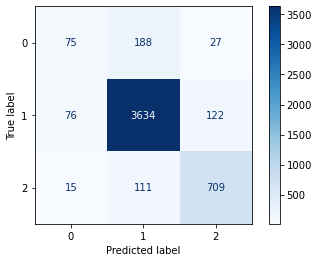

In [36]:
##SVC model
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
classNames = np.unique(y_test)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)
## plotting confusion matrix for better visualization
print(confusion_matrix( y_test, y_preds))
plottedCM_Level_A = plot_confusion_matrix(support,  X_test_bow , y_test ,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()

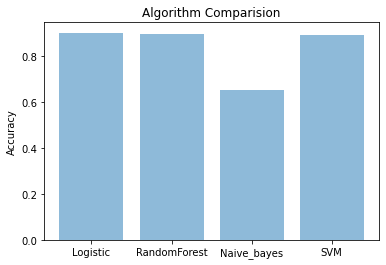

In [27]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

In [28]:
testing_index=list(X_test_bow.index[0:10])
#print(testing_index)
print("Predicted Class:",y_preds[0:10])
print("Actual Class:",y_test.tolist()[0:10])

Predicted Class: [1 1 1 1 1 1 1 1 1 1]
Actual Class: [1, 1, 2, 1, 1, 1, 1, 1, 1, 1]


Text(0, 0.5, 'Count')

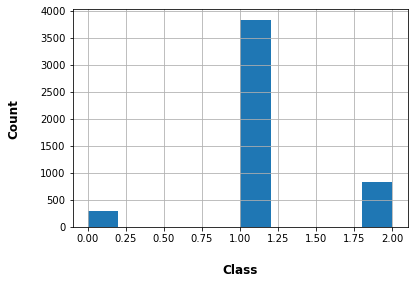

In [29]:
# Histogram presenting the count of different classes- Actual
ax=y_test.hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

Text(0, 0.5, 'Count')

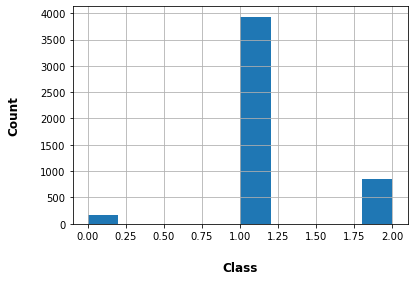

In [30]:
# Histogram presenting the count of different classes- Predicted
ax=panda.Series(y_preds).hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)